In [1]:
import pandas as pd
import numpy as np
import time
import re
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
class AFNDP():

    def auto_run(self, ):
        self.afd_graph = dict()
        E = input().split(" ") #list of states
        alphabet = input().split(" ") #alphabet
        alphabet_stack = input().split(" ")

        #----- set states ------
        alphabet.append("*")
        alphabet_stack.append("*")
        for e in E:
            for c in alphabet:
                for a_s in alphabet_stack:
                    self.afd_graph[(e, c, a_s)] = []

        n = int(input()) #n transactions

        for i in range(n):
            s = input().split(" ")
            self.afd_graph[(s[0], s[1], s[2])].append((s[3], list(s[4])))

        self.init_state = str(input())

        self.final_states = str(input()).split(" ")

        words = input().split(" ")

        for word in words:
            print(self.extended_delta(word))

    def extended_delta(self, word):
        if not word:
            word = "*"
        states_stack = [(self.init_state, word, ["*"])] # (current state, remaining chars, stack)
        
        while states_stack:
            c_ste, word_i, stack = states_stack.pop()
            stack = self.clear_lambda(stack)

            #what transactions we have to state c_ste receiving word_i and unstacking stack.pop() elements:
            new_states = self.afd_graph.get((c_ste, word_i[0], stack[-1]), [])  #get a state and the word to be stacked
            if self.delta(word_i, new_states, stack[0:-1], states_stack):
                return "S"

            new_states = self.afd_graph.get((c_ste, word_i[0], "*"), []) #Seach for transaction consuming a char and not unstacking
            if self.delta(word_i, new_states, stack, states_stack):
                return "S"

            new_states = self.afd_graph.get((c_ste, "*", stack[-1]), []) #Seach for transaction without consuming a char and unstacking
            if self.delta("*"+word_i, new_states, stack[0:-1], states_stack):
                return "S"
                
            new_states = self.afd_graph.get((c_ste, "*", "*"), []) #without consuming char and unstacking
            if self.delta("*"+word_i, new_states, stack, states_stack):
                return "S"
        
        return "N"
        
    def is_empty(self, l):
        for e in l:
            if e != "*":
                return False

        return True

    def clear_lambda(self, l):
        new_l = ["*"]
        for e in l:
            if e != "*":
                new_l.append(e)
        return new_l

    def delta(self, word_i, new_states, stack, states_stack):
        
        for new_e, word_stack in new_states:
            
            if not self.is_empty(word_stack): 
                word_stack = stack + word_stack #insert the new word of the new e on the stack
            else:
                word_stack = stack.copy()

            if new_e in self.final_states and not word_i[1:].replace("*", "") and self.is_empty(word_stack):
                return True #is accepted

            r_word = word_i[1:]
            if not word_i[1:]:
                r_word = "*"

            states_stack.append((new_e, r_word, word_stack.copy()))

        return False

    def setup(self, definition):
        self.afd_graph = dict()
        E = definition["E"].split(" ") #list of states
        alphabet = definition["alphabet"].split(" ") #alphabet
        alphabet_stack = definition["alphabet_stack"].split(" ")

        #----- set states ------
        alphabet.append("*")
        alphabet_stack.append("*")
        for e in E:
            for c in alphabet:
                for a_s in alphabet_stack:
                    self.afd_graph[(e, c, a_s)] = []

        #n = int(definition["n"]) #n transactions

        for t in definition["afd_graph"].split(";"):
            s = t.split(" ")
            self.afd_graph[(s[0], s[1], s[2])].append((s[3], list(s[4])))

        self.init_state = definition["init_state"]
        self.final_states = definition["final_states"].split(" ")


### Results

#### Generate words

In [19]:
## Generate to many words
words = []
for k in np.arange(0, 34, 1):
    ones = str(np.ones(int(k/2)).astype(int))[1:-1].replace(" ","").replace("\n", "")
    zeros = str(np.zeros(int(k/2)).astype(int))[1:-1].replace(" ","").replace("\n", "")
    words.append(zeros+ones)
words_df = pd.DataFrame({"words":words})

In [20]:
words_df.to_csv("words_01.csv", index=False)

In [21]:
words_df = pd.read_csv("words_01.csv")
words_df.loc[0, "words"] = "*"

#### Test

In [44]:
definitions

,i,qtd_E,E,alphabet,alphabet_stack,n,afd_graph,init_state,final_states,a,b,c
0,0,2,0 1,0 1,A,nan,0 0 * 0 A;0 1 A 1 *;1 1 A 1 *;1 1 * 1 *,0,1,1.987584,0.360637,13.994396
1,1,2,i j,0 1,A,nan,i 0 * i A;i 0 * i AA;i * * j *;j 1 A j *,i,j,0.000364,0.376381,2.464800
2,3,1,0,0 1,U Z,nan,0 0 * 0 Z;0 0 U 0 *;0 1 * 0 *;0 1 Z 0 *,0,0,7.347608,0.352769,14.105498


In [41]:
afndp = AFNDP()
definitions  = pd.read_csv("afndps.csv").astype(str)
definitions = definitions[definitions['alphabet'] == "0 1"]
tests = []

for i in definitions.index[1:]:
    row_i = definitions.iloc[i]

    print("AFND Nº", i)
    afndp.setup(row_i)
    w = 0
    for word in words:
        start_time = time.time()
        afndp.extended_delta(word)
        end_time = time.time()
        
        #store the result
        tests.append({"w":w, "i": i, "qtd_s": row_i['qtd_E'], "len_w": len(word), "delta_T": (end_time-start_time)})

        print(len(word), end="\r")
        w += 1

tests = pd.DataFrame(tests)

AFND Nº 1
AFND Nº 2


In [42]:
tests_t = pd.read_csv("tests_algorithm_01.csv")
tests_t = tests_t[tests_t.i == 0]
tests = tests.append(tests_t)

tests.to_csv("tests_algorithm_01.csv", index=False)

C:\Users\Joel\AppData\Local\Temp\ipykernel_12052\737472565.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tests = tests.append(tests_t)


## Curve adjustment

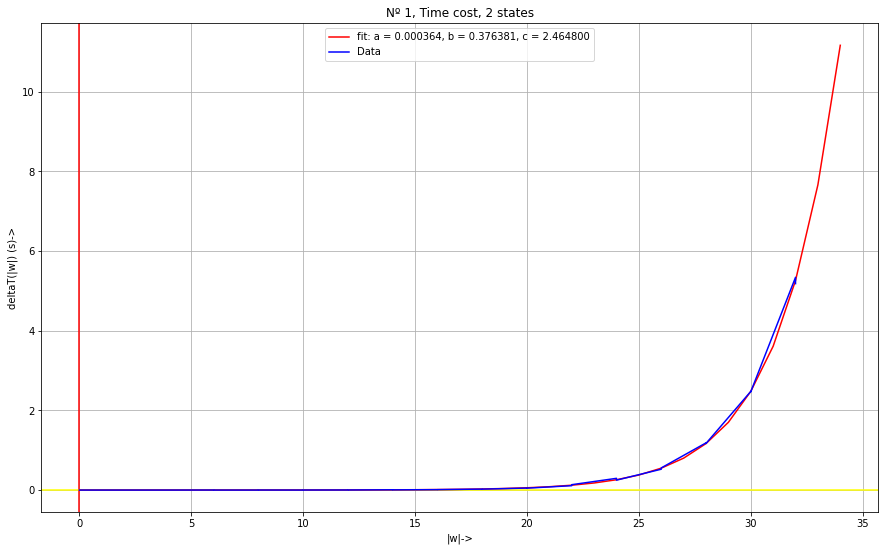

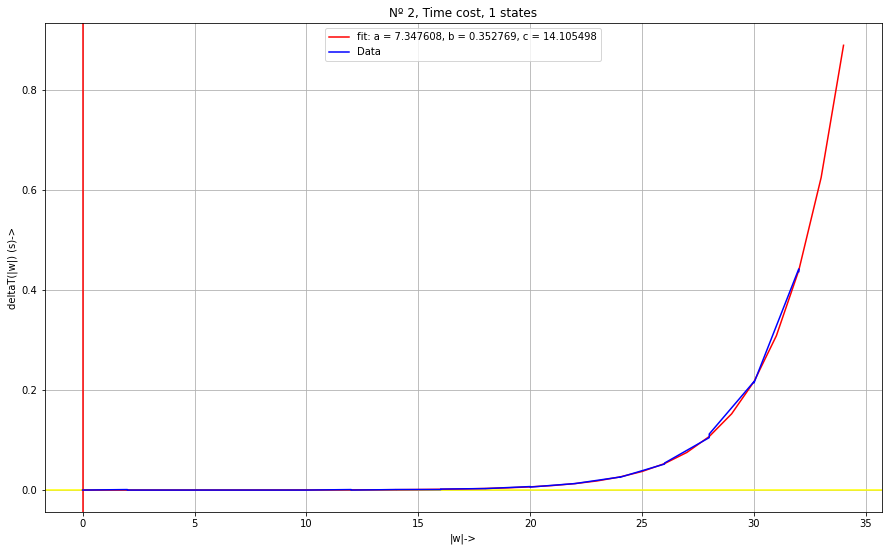

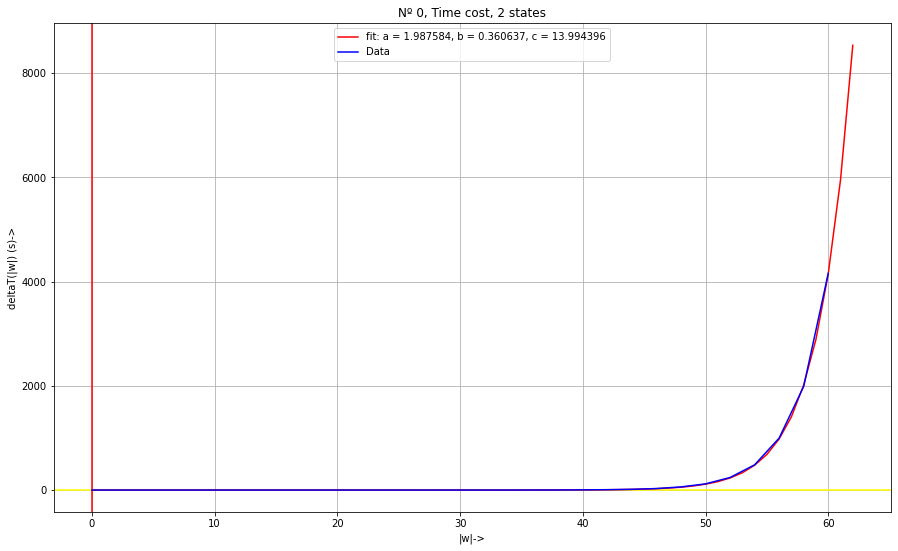

In [43]:
#choose the model
def func(x, a, b, c):
    return a*np.exp(b*x-c)

#fit
for i in tests.i.unique():
    test_i = tests[tests.i == i]
    popt, pcov = curve_fit(func, test_i.len_w, test_i.delta_T)

    #parameters found to curve fitted
    definitions.loc[i,'a'] = popt[0]
    definitions.loc[i,'b'] = popt[1]
    definitions.loc[i,'c'] = popt[2]

    #plot the result
    x = np.arange(0, test_i.len_w.max()+3, 1)

    fig, ax = plt.subplots(figsize=(15, 9))
    
    ax.axvline(x=0, color='red')
    ax.axhline(y=0, color='yellow')

    ax.plot(x, func(x, *popt), 'r-', label='fit: a = %f, b = %f, c = %f'%tuple(popt))
    ax.plot(test_i.len_w, test_i.delta_T, 'b-', label='Data')

    ax.set(xlabel='|w|->', ylabel='deltaT(|w|) (s)->',
            title="Nº "+str(i)+", Time cost, "+str(test_i.qtd_s.iloc[0])+" states")
    ax.grid()
    ax.legend()
    plt.show()

The relative error is as follow: 

$ RE = \dfrac{|y-y_{pred}|}{y} $

In [64]:
#lets calculate the error
tests['y_exp'] = func(tests.len_w, *popt)
tests['error'] = np.abs(test_i.delta_T - tests['y_exp'])/test_i.delta_T
tests['mse'] = mean_squared_error(test_i.delta_T, tests['y_exp'] )

### Adjustment with linear

In [ ]:
tests['logT'] = np.log(tests.delta_T)

def linear(x, a, b):
    return a*x+b

popt, pcov = curve_fit(func, test_i.len_w, test_i.delta_T)

In [ ]:
x = np.arange(0, 63, 1)

fig, ax = plt.subplots(figsize=(15, 9))
    
ax.axvline(x=0, color='red')
ax.axhline(y=0, color='yellow')

ax.plot(x, np.log(func(x, *popt)), 'r-', label='fit: a = %f, b = %f, c = %f'%tuple(popt))
ax.plot(test_i.len_w, np.log(test_i.delta_T), 'b-', label='Data')

ax.set(xlabel='|w|->', ylabel='deltaT(|w|) ->',
        title="Time cost, "+str(test_i.qtd_s.iloc[0])+" states")
ax.grid()
ax.legend()
plt.show()